In [1]:
import tensorflow as tf
import numpy as np 
import random 
import matplotlib.pyplot as plt 

In [2]:
# Defining some key methods
def label_to_output(label):
    o = [0]*10
    o[label] = 1
    return o

def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

def d_sigmoid(x):
    return sigmoid(x) * (1-sigmoid(x))

def get_loss(y, label):
    return ((0.5/y.shape[0]) * np.sum((y-label)**2))

def validate():
    x = x_test
    label = test_labels 
    m = x.shape[0]

    # Forward Pass
    layer_input = x.reshape(-1, 784, 1)
    a1 = sigmoid(np.matmul(fcl_w, layer_input) + fcl_b)
    y = sigmoid(np.matmul(output_w, a1) + output_b)

    predictions = np.argmax(y, axis = 1)
    equals = predictions == y_test.reshape(m, 1)

    loss = get_loss(y, label.reshape(-1, 10, 1))

    return loss, np.average(equals)

In [5]:
# Load data, normalize, convert labels to array

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train/255, x_test/255

TRAIN_LENGTH = len(x_train) # 60000
TEST_LENGTH = len(x_test) # 10000

train_labels = np.zeros((TRAIN_LENGTH, 10))
for i, label in enumerate(y_train):
    train_labels[i] = (label_to_output(label))

test_labels = np.zeros((TEST_LENGTH, 10))
for i, label in enumerate(y_test):
    test_labels[i] = (label_to_output(label))

In [36]:
lr = 0.05
epochs = 10

batch_size = 1
train_loader = x_train.reshape(-1, batch_size, 28, 28)
label_loader = train_labels.reshape(-1, batch_size, 10, 1)

fcl_w = 2 * np.random.rand(64, 784) - 1 
fcl_b = 2 * np.random.rand(64,  1 ) - 1 

output_w = 2 * np.random.rand(10, 64) - 1 
output_b = 2 * np.random.rand(10,  1) - 1

running_loss = 0
running_accuracy = 0

history = {'loss':[], 
           'cv_loss':[], 
           'accuracy':[],
           'cv_accuracy':[]}

for e in range(epochs):
    print(f'Epoch {e+1}:')
    running_loss = 0
    running_accuracy = 0
    for i, batch in enumerate(train_loader):
    # for i in range(1):

        x = train_loader[i]
        label = label_loader[i]
        m = x.shape[0]

        # Forward Pass
        layer_input = x.reshape(-1, 784, 1)
        
        z1 = np.matmul(fcl_w, layer_input) + fcl_b
        a1 = sigmoid(z1)
        
        z2 = np.matmul(output_w, a1) + output_b
        y  = sigmoid(z2)

        # Error computation
        output_error = (y - label) * d_sigmoid(z2)
        fcl_error    = np.matmul(output_w.transpose(), output_error) * d_sigmoid(z1)

        predictions = np.argmax(y, axis = 1)
        l = np.argmax(label, axis = 1)
        equals = predictions == l.reshape(m, 1)
        running_accuracy += np.average(equals)
        running_loss += get_loss(y, label)

        # Gradient descent
        output_w_grad = np.sum(np.matmul(output_error, np.einsum('ijk->ikj', a1)),          axis = 0)
        fcl_w_grad    = np.sum(np.matmul(fcl_error,    np.einsum('ijk->ikj', layer_input)), axis = 0)
        
        output_b_grad = np.sum(output_error, axis = 0)
        fcl_b_grad    = np.sum(fcl_error   , axis = 0)

        output_w = output_w - (lr/m) * output_w_grad
        output_b = output_b - (lr/m) * output_b_grad

        fcl_w    = fcl_w    - (lr/m) * fcl_w_grad
        fcl_b    = fcl_b    - (lr/m) * fcl_b_grad

        # Cross validation
        datapoints = 1 # log this many times
        every = 60000 / (batch_size * datapoints)
        if (i+1) % every == 0:
            loss = running_loss / every
            accuracy = running_accuracy / every

            cv_loss, cv_accuracy = validate()

            print('Epoch {}, accuracy = {:.2%} loss = {:.3f}; CV accuracy = {:.2%} loss = {:.3f}'.format(
                    e+1, 
                    accuracy,
                    loss,
                    cv_accuracy,
                    cv_loss))

            history['loss'].append(loss)
            history['accuracy'].append(accuracy)
            history['cv_loss'].append(cv_loss)
            history['cv_accuracy'].append(cv_accuracy)

            running_loss = 0
            running_accuracy = 0


Epoch 1:
Epoch 1, accuracy = 78.65% loss = 0.159; CV accuracy = 90.33% loss = 0.083
Epoch 2:
Epoch 2, accuracy = 91.82% loss = 0.072; CV accuracy = 92.66% loss = 0.063
Epoch 3:
Epoch 3, accuracy = 93.35% loss = 0.059; CV accuracy = 93.48% loss = 0.055
Epoch 4:
Epoch 4, accuracy = 94.19% loss = 0.051; CV accuracy = 94.15% loss = 0.050
Epoch 5:
Epoch 5, accuracy = 94.80% loss = 0.046; CV accuracy = 94.59% loss = 0.047
Epoch 6:
Epoch 6, accuracy = 95.27% loss = 0.042; CV accuracy = 94.89% loss = 0.044
Epoch 7:
Epoch 7, accuracy = 95.62% loss = 0.039; CV accuracy = 95.15% loss = 0.042
Epoch 8:
Epoch 8, accuracy = 95.94% loss = 0.037; CV accuracy = 95.33% loss = 0.041
Epoch 9:
Epoch 9, accuracy = 96.18% loss = 0.034; CV accuracy = 95.38% loss = 0.039
Epoch 10:
Epoch 10, accuracy = 96.38% loss = 0.033; CV accuracy = 95.45% loss = 0.038


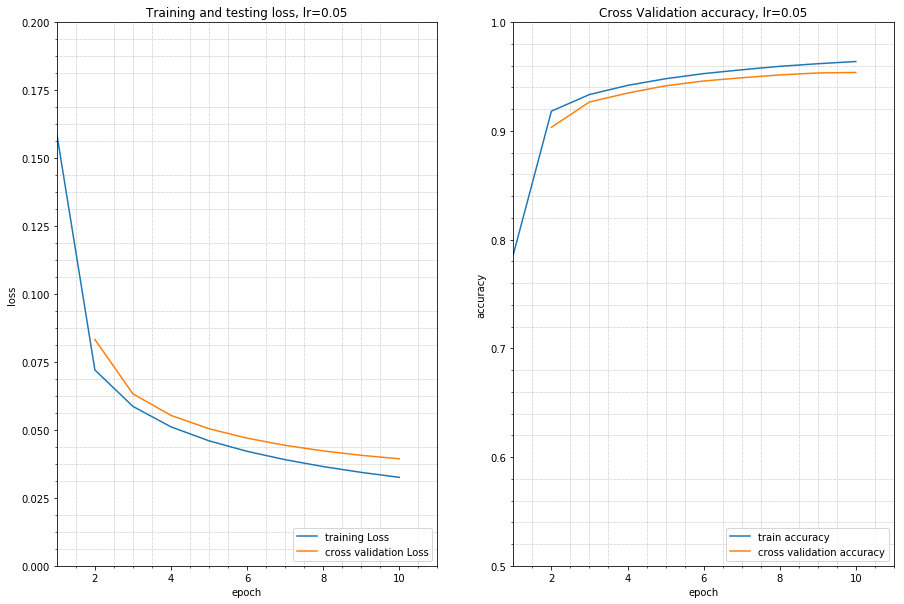

In [40]:
image = 0

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 10)

n = datapoints * epochs
x = np.arange(n) + 1

axs[0].plot(x, history['loss'], label = 'training Loss')
axs[0].plot(x[1:], history['cv_loss'][:n-1], label = 'cross validation Loss')
axs[0].set_ylabel('loss')
axs[0].set(xlim=[1, 11], ylim=[0, 0.2])
axs[0].set_title('Training and testing loss, lr={}'.format(lr))

axs[1].plot(x, history['accuracy'], label = 'train accuracy')
axs[1].plot(x[1:], history['cv_accuracy'][:n-1], label = 'cross validation accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set(xlim=[1, 11], ylim=[0.5, 1])
axs[1].set_title('Cross Validation accuracy, lr={}'.format(lr))

for ax in axs:
    ax.legend(loc = 'lower right', markerscale=20)
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.set_xlabel('epoch')

filename = 'images/MLN_loss_{}.png'.format(image)

plt.savefig(filename, dpi = 300)


In [42]:
# np.save('MLN_weights/fcl_w', fcl_w)
# np.save('MLN_weights/fcl_b', fcl_b)
# np.save('MLN_weights/output_w', output_w)
# np.save('MLN_weights/output_b', output_b)

In [ ]:
pass

In [ ]:
'''
MLN algorithm:: 

* Input: (m) x 784 x 1

* FCL:   64 neurons
* FCL_w: (64 x 784)
* FCL_b: (64 x 1)

* output layer: 10 neurons
* output_w:     (10 x 64)
* output_b:     (10 x 1)


Forward: 
* x -> Input                                    m x 784 x 1

* z1 = FCL_w * Input + FCL_b                    m x 64 x 1 
* a1 = sigmoid(z1)

* z2 = output_w * a1 + output_b                 m x 10 x 1
* y  = sigmoid(z2)                              

Backward: 

Step 1: Error
* output_error  = (y - label) .* d_sigmoid(z2)                           m x 10 x 1

                   (10 x 64)^T     m x 10 x 1     m x 64 x 1
* FCL_error     = ( output_w^T * output_error) .* (d_sigmoid(z1))        m x 64 x 1


Step 2: Gradient descent

                 (10 x 64)    constant           m x 10 x 1   m x (64 x 1)^T
* output_w      = output_w - (alpha / m) * sum( output_error  *    a1^T      )     10 x 64

                  (64 x 1)    constant           m x 64 x 1
* output_b      = output_b - (alpha / m) * sum( output_error )

                 (64 x 784)   constant           m x 64 x 1   m x (784 x 1)^T  
* FCL_w         = FCL_w    - (alpha / m) * sum( FCL_error     *    Input^T   )     64 x 784

                  (10 x 1)    constant           m x 10 x 1
* FCL_b         = FCL_b    - (alpha / m) * sum( fcl_error )


'''
pass